In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import  make_scorer
# from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/robertasgabrys/DSO559/main/AllDayBouncing.csv')
df.head()

,SeniorCitizen,WeekendBouncer,avgBounceTime,bounceInStreet,phoneType,avgBounceDistance,avgBounceHeight,PaperlessBilling,monthlyDistanceBounced,totalDistanceBounced,Churn
0,No,No,1,No,Unknown,<1 ft.,<1 ft.,Yes,29.85,29.85,No_Churn
1,No,No,34,Yes,Unknown,<1 ft.,1-2 ft.,No,56.95,1889.50,No_Churn
2,No,No,2,Yes,Unknown,<1 ft.,<1 ft.,Yes,53.85,108.15,Churn
3,No,No,45,No,Unknown,1-4 ft.,1-2 ft.,No,42.30,1840.75,No_Churn
4,No,No,2,Yes,Android,<1 ft.,<1 ft.,Yes,70.70,151.65,Churn


In [3]:
# 10
print(len(df))
print(df.Churn.value_counts())
print(df.Churn.value_counts()['Churn']*20)
print(df.Churn.value_counts(normalize=True))

7043
No_Churn    5174
Churn       1869
Name: Churn, dtype: int64
37380
No_Churn    0.73463
Churn       0.26537
Name: Churn, dtype: float64


<Axes: xlabel='avgBounceTime', ylabel='Count'>

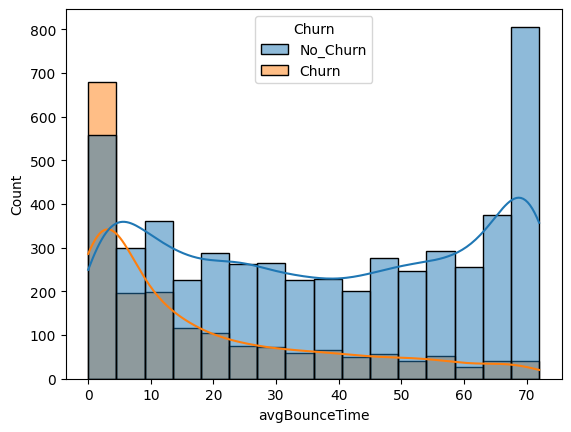

In [4]:
# 11
sns.histplot(data = df,x='avgBounceTime',hue='Churn',kde=True)

In [5]:
#12
# Remove them from the data set
df = df[df.avgBounceTime!=0]

In [6]:
# Recode Churn
df = df.assign(Churn = df['Churn'].map({'Churn':1,'No_Churn':0}))

In [7]:
# Create X and y objects.
X = df.drop('Churn', axis=1)
X = pd.get_dummies(X,drop_first=False) # transform categorical non numeric columns to dummies, numeric columns are not affected by this function
y = df['Churn']

In [8]:
# Randomly divide data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 1)

In [9]:
M = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10,random_state=1).fit(X_train,y_train)

In [10]:
# dot_data = export_graphviz(M, feature_names = X_train.columns,class_names=['0','1'],filled=True,proportion=True)
# graph = graphviz.Source(dot_data)
# display(graph)

In [11]:
# What is the proportion of correct predictions of testing set?
print(M.score(X_train,y_train))
print(M.score(X_test,y_test))

0.8396993092238927
0.7696682464454976


In [12]:
# What is the recall on both? Recall = proportion of correctly predicted churns
print("Training set", round(metrics.recall_score(y_true = y_train, y_pred = M.predict(X_train))*100,2))
print("Testing set", round(metrics.recall_score(y_true = y_test, y_pred = M.predict(X_test))*100,2))

Training set 62.02
Testing set 52.43


In [13]:
# What is the precission on both? Precision = proportion of of predicted churns that are actually churns
print("Training set", round(metrics.precision_score(y_true = y_train, y_pred = M.predict(X_train))*100,2))
print("Testing set", round(metrics.precision_score(y_true = y_test, y_pred = M.predict(X_test))*100,2))

Training set 73.76
Testing set 56.73


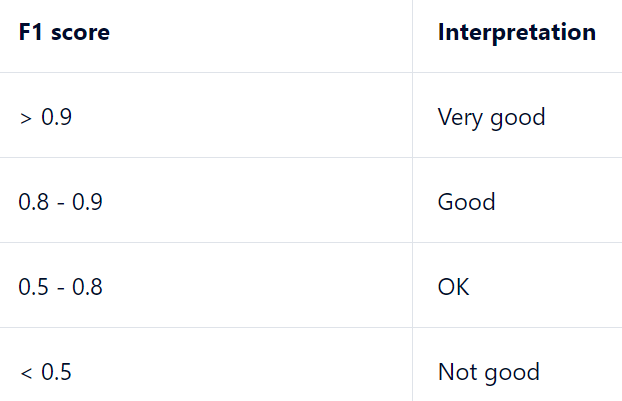

In [14]:
# Notice that F1-score takes both precision and recall into account, which also means it accounts for both FPs and FNs. 
# The higher the precision and recall, the higher the F1-score. F1-score ranges between 0 and 1. The closer it is to 1, the better the model.
# F1 score can be interpreted as a measure of overall model performance from 0 to 1, where 1 is the best. 
# To be more specific, F1 score can be interpreted as the model’s balanced ability to both capture positive cases (recall) and 
# be accurate with the cases it does capture (precision).
print("Training set", round(metrics.f1_score(y_true = y_train, y_pred = M.predict(X_train))*100,2))
print("Testing set", round(metrics.f1_score(y_true = y_test, y_pred = M.predict(X_test))*100,2))

Training set 67.38
Testing set 54.49


In [15]:
#13
thresholds = [0.2,0.4,0.6,0.8]
# misclassification error = 1 - accuracy
misclassification_errors = [1-metrics.accuracy_score(y_true = y_test, y_pred = (M.predict_proba(X_test)[:,1] >= threshold)*1) for threshold in thresholds]
np.array(thresholds)[misclassification_errors==min(misclassification_errors)]

array([0.6])

In [16]:
#14
threshold = 0.45
confusionMatrix = pd.crosstab(index = y_test, columns = (M.predict_proba(X_test)[:,1] >= threshold)*1,
                              margins = True,margins_name="Total",colnames=['Predicted Churn'],rownames=['Actual Churn'])
confusionMatrix

Predicted Churn,0,1,Total
Actual Churn,,,
0,1310,245,1555
1,238,317,555
Total,1548,562,2110


In [17]:
print((1310+317)/2110)
print(555/2110)
print(1548/2110)
print(317/555)
print(238)

0.771090047393365
0.26303317535545023
0.7336492890995261
0.5711711711711712
238


In [18]:
#15
membership = 20
discount = 0.2
postage = 1
renewalRate = 0.5

TN = confusionMatrix.loc[0,0]
FP = confusionMatrix.loc[0,1]
FN = confusionMatrix.loc[1,0]
TP = confusionMatrix.loc[1,1]

revenueNoModel = membership * confusionMatrix.loc[0,'Total'] 
print(revenueNoModel)

revenue = membership * TN + (membership*(1-discount) + postage) * FP +\
0 * FN + (membership*(1-discount) + postage) * renewalRate * TP + 0 * (1-renewalRate) * TP

print(revenue)

31100
33059.5


In [19]:
#16
thresholds = np.linspace(0,1,100)
AccuracyScores = [round(metrics.accuracy_score(y_true = y_test, y_pred = (M.predict_proba(X_test)[:,1] >= threshold)*1)*100,2) for threshold in thresholds]
RecallScores = [round(metrics.recall_score(y_true = y_test, y_pred = (M.predict_proba(X_test)[:,1] >= threshold)*1)*100,2) for threshold in thresholds]
PrecissionScores = [round(metrics.precision_score(y_true = y_test, y_pred = (M.predict_proba(X_test)[:,1] >= threshold)*1)*100,2) for threshold in thresholds]
F1Scores = [round(metrics.f1_score(y_true = y_test, y_pred = (M.predict_proba(X_test)[:,1] >= threshold)*1)*100,2) for threshold in thresholds]

In [20]:
print('Optimal accuracy threshold',thresholds[AccuracyScores==max(AccuracyScores)])
print('Optimal recall threshold',thresholds[RecallScores==max(RecallScores)])
print('Optimal F1 threshold',thresholds[F1Scores==max(F1Scores)])
print('Optimal precision threshold',thresholds[PrecissionScores==max(PrecissionScores)])

Optimal accuracy threshold [0.63636364]
Optimal recall threshold [0.]
Optimal F1 threshold [0.31313131]
Optimal precision threshold [0.91919192]


In [21]:
threshold = thresholds[AccuracyScores==max(AccuracyScores)]
confusionMatrix = pd.crosstab(index = y_test, columns = (M.predict_proba(X_test)[:,1] >= threshold)*1,
                              margins = True,margins_name="Total",colnames=['Predicted Churn'],rownames=['Actual Churn'])
TN = confusionMatrix.loc[0,0]
FP = confusionMatrix.loc[0,1]
FN = confusionMatrix.loc[1,0]
TP = confusionMatrix.loc[1,1]
revenue = membership * TN + (membership*(1-discount) + postage) * FP +\
0 * FN + (membership*(1-discount) + postage) * renewalRate * TP + 0 * (1-renewalRate) * TP
revenue

32567.0

In [22]:
threshold = thresholds[RecallScores==max(RecallScores)]
confusionMatrix = pd.crosstab(index = y_test, columns = (M.predict_proba(X_test)[:,1] >= threshold)*1,
                              margins = True,margins_name="Total",colnames=['Predicted Churn'],rownames=['Actual Churn'])
TN = 0 # confusionMatrix.loc[0,0] there are no TN's for threshold of 0
FP = confusionMatrix.loc[0,1]
FN = 0 # confusionMatrix.loc[1,0] there are no TN's for threshold of 0
TP = confusionMatrix.loc[1,1]
revenue = membership * TN + (membership*(1-discount) + postage) * FP +\
0 * FN + (membership*(1-discount) + postage) * renewalRate * TP + 0 * (1-renewalRate) * TP
revenue

31152.5

In [23]:
threshold = thresholds[F1Scores==max(F1Scores)]
confusionMatrix = pd.crosstab(index = y_test, columns = (M.predict_proba(X_test)[:,1] >= threshold)*1,
                              margins = True,margins_name="Total",colnames=['Predicted Churn'],rownames=['Actual Churn'])
TN = confusionMatrix.loc[0,0]
FP = confusionMatrix.loc[0,1]
FN = confusionMatrix.loc[1,0]
TP = confusionMatrix.loc[1,1]
revenue = membership * TN + (membership*(1-discount) + postage) * FP +\
0 * FN + (membership*(1-discount) + postage) * renewalRate * TP + 0 * (1-renewalRate) * TP
revenue

33271.5

In [24]:
threshold = thresholds[PrecissionScores==max(PrecissionScores)]
confusionMatrix = pd.crosstab(index = y_test, columns = (M.predict_proba(X_test)[:,1] >= threshold)*1,
                              margins = True,margins_name="Total",colnames=['Predicted Churn'],rownames=['Actual Churn'])
TN = confusionMatrix.loc[0,0]
FP = confusionMatrix.loc[0,1]
FN = confusionMatrix.loc[1,0]
TP = confusionMatrix.loc[1,1]
revenue = membership * TN + (membership*(1-discount) + postage) * FP +\
0 * FN + (membership*(1-discount) + postage) * renewalRate * TP + 0 * (1-renewalRate) * TP
revenue

31675.5